In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits

df = summarize_fits('../results', truths='aigrain')
df.head()

/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,ln_A_05,ln_A_16,ln_A_50,ln_A_84,ln_A_95,ln_l_05,ln_l_16,ln_l_50,ln_l_84,ln_l_95,...,ln_sigma_84,ln_sigma_95,ln_period_05,ln_period_16,ln_period_50,ln_period_84,ln_period_95,aigrain_p_min,aigrain_p_max,aigrain_p_mean
0,-19.674894,-19.154522,-17.663051,-15.534701,-14.424018,-0.601711,-0.487261,-0.130736,0.445269,0.874366,...,-14.364028,-13.967978,1.322768,1.465259,1.787341,2.156775,2.500429,0.118834,0.665654,0.392244
1,-19.681155,-19.016712,-17.012013,-15.085878,-13.836773,-0.594285,-0.410720,0.118387,0.959641,1.604687,...,-16.785139,-15.529145,1.492209,1.687393,2.092145,2.553577,2.886728,0.504317,0.835014,0.669665
2,-12.736784,-12.648869,-12.505395,-12.360794,-12.260575,5.478327,5.641705,5.974841,6.107318,6.186240,...,-18.181302,-18.159687,2.841588,2.888304,3.050613,3.074058,3.088128,2.835564,2.835564,2.835564
3,-12.370090,-12.243328,-12.052451,-11.844526,-11.700898,9.233400,9.398853,9.623005,9.833467,9.970608,...,-16.431785,-16.410419,3.770433,3.778826,3.790203,3.802187,3.810955,3.746606,3.929346,3.837976
4,-11.183059,-11.034925,-10.774832,-10.490658,-10.288939,9.547550,9.861482,10.292702,10.732024,11.006483,...,-14.135817,-14.116854,4.018619,4.044674,4.083382,4.129561,4.162387,3.927628,4.534838,4.231233


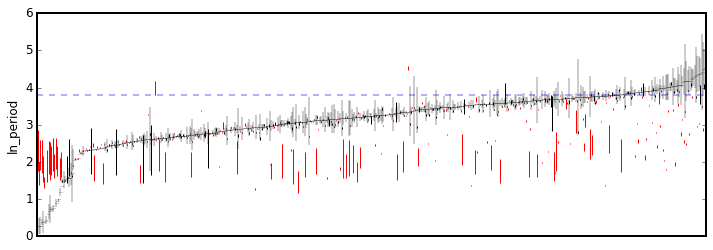

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

p_mean = (df.aigrain_p_min + df.aigrain_p_max)/2.
inds = df.index[np.argsort(p_mean)]

fig, ax = plt.subplots(1, 1, figsize=(12,4))
lines = []
labels = []
colors = []
for i,ix in enumerate(inds):
    ymin, ymax = df.ix[ix, ['aigrain_p_min', 'aigrain_p_max']]
    ymean = (ymin + ymax)/2.
    ax.plot([i,i], [ymin, ymax], color='k', alpha=0.2)
    ax.plot([i-0.5, i+1.5], [ymean, ymean], color='k', lw=1, alpha=0.2)
    
    ylo, yhi = df.ix[ix, ['ln_period_16', 'ln_period_84']]
    if (yhi < ymin) or (ylo > ymax):
        color='r'
    else:
        color='k'
    lines.append(([i,ylo], [i,yhi]))
    colors.append(color)
    labels.append(ix)

collection = LineCollection(lines, colors=colors, linewidths=1)
ax.add_collection(collection)
ax.set_xlim((-0.5, i+0.5))
ax.set_xticks([]);
ax.set_ylabel('ln_period');
ax.plot([-0.5, i+0.5], [np.log(45), np.log(45)], ls='--', color='b', alpha=0.3);

tooltip = mpld3.plugins.PointLabelTooltip(collection, labels=labels)
plugins.connect(fig, tooltip)